# World Development Indicators Data Analysis and Visualization

This project is based on the World Bank Development Indicators data (WDI_cleaned_1975_2023.csv), comparing the Pre period (2010-2014) and Post period (2015-2019).

## Core Indicators
1. Inflation (Inflation Rate)
2. Unemployment (Unemployment Rate)
3. Trade (Trade as % of GDP)
4. Debt (Government Debt Ratio)
5. Credit_to_Private_Sector (Private Sector Credit Ratio)


## 1. Environment Setup and Data Loading


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings('ignore')

# Set font for better visualization (optional)
plt.rcParams['axes.unicode_minus'] = False

# Create necessary folders
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('fig', exist_ok=True)


In [2]:
# Load data
df = pd.read_csv('WDI_cleaned_1975_2023.csv', encoding='utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst 5 rows:")
df.head()


Dataset shape: (11929, 11)

Column names:
['Country Name', 'Country Code', 'Year', 'NPLs', 'Inflation', 'Credit_to_Private_Sector', 'Debt', 'Trade', 'GDP', 'GDP_Growth', 'Unemployment']

First 5 rows:


Country Name Country Code  Year  NPLs  Inflation  Credit_to_Private_Sector  \
0  Afghanistan          AFG  2000   NaN        NaN                       NaN   
1  Afghanistan          AFG  2001   NaN        NaN                       NaN   
2  Afghanistan          AFG  2002   NaN        NaN                       NaN   
3  Afghanistan          AFG  2003   NaN        NaN                       NaN   
4  Afghanistan          AFG  2004   NaN        NaN                       NaN   

   Debt  Trade           GDP  GDP_Growth  Unemployment  
0   NaN    NaN  3.521418e+09         NaN           NaN  
1   NaN    NaN  2.813572e+09   -9.431974           NaN  
2   NaN    NaN  3.825701e+09   28.600001           NaN  
3   NaN    NaN  4.520947e+09    8.832278           NaN  
4   NaN    NaN  5.224897e+09    1.414118           NaN

## 2. Exploratory Data Analysis


In [3]:
# View basic data information
print("Basic data information:")
print(df.info())
print("\n" + "="*80 + "\n")

# View statistical description of numeric columns
print("Statistical description of numeric columns:")
df.describe()


Basic data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              11929 non-null  object 
 1   Country Code              11929 non-null  object 
 2   Year                      11929 non-null  int64  
 3   NPLs                      2105 non-null   float64
 4   Inflation                 5592 non-null   float64
 5   Credit_to_Private_Sector  8307 non-null   float64
 6   Debt                      1745 non-null   float64
 7   Trade                     9413 non-null   float64
 8   GDP                       11755 non-null  float64
 9   GDP_Growth                11599 non-null  float64
 10  Unemployment              5530 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.0+ MB
None


Statistical description of numeric columns:


Year         NPLs    Inflation  Credit_to_Private_Sector  \
count  11929.000000  2105.000000  5592.000000               8307.000000   
mean    2000.061782     6.748363    11.892900                 45.520840   
std       13.866814     7.907829    80.100487                 41.627026   
min     1975.000000     0.092335   -16.859691                  0.000088   
25%     1989.000000     2.132705     2.039051                 15.541302   
50%     2001.000000     3.965531     3.997525                 32.141168   
75%     2012.000000     8.375967     7.869363                 59.204987   
max     2023.000000    61.116041  2947.732772                304.575113   

              Debt        Trade           GDP    GDP_Growth  Unemployment  
count  1745.000000  9413.000000  1.175500e+04  11599.000000   5530.000000  
mean     54.604128    76.462976  1.420896e+12      3.324442      7.950586  
std      42.396262    50.823112  6.046968e+12      6.159107      5.752072  
min      -1.170726     0.020999  3.669420e+06    -64.047107      0.039000  
25%      30.296628    45.422943  3.245520e+09      1.187737      4.154500  
50%      48.955279    63.948960  2.202271e+10      3.542718      6.679127  
75%      68.450949    94.647570  2.749799e+11      5.799484      9.997950  
max     865.873243   863.195099  1.069392e+14    149.972963     57.000000

In [4]:
# View year range
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nNumber of countries: {df['Country Name'].nunique()}")
print(f"\nRecords per year: {df.groupby('Year').size().describe()}")


Year range: 1975 - 2023

Number of countries: 264

Records per year: count     49.000000
mean     243.448980
std       20.843725
min      201.000000
25%      226.000000
50%      252.000000
75%      259.000000
max      262.000000
dtype: float64


Core indicators missing value statistics:
                          Missing Count  Missing Rate(%)
Inflation                          6337            53.12
Unemployment                       6399            53.64
Trade                              2516            21.09
Debt                              10184            85.37
Credit_to_Private_Sector           3622            30.36


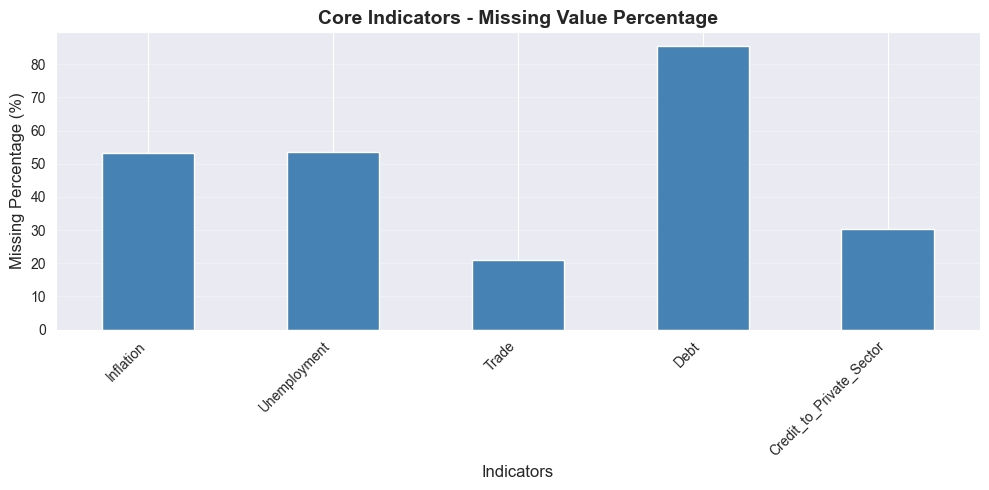

In [5]:
# Missing values for core indicators
core_indicators = ['Inflation', 'Unemployment', 'Trade', 'Debt', 'Credit_to_Private_Sector']

print("Core indicators missing value statistics:")
missing_stats = pd.DataFrame({
    'Missing Count': df[core_indicators].isnull().sum(),
    'Missing Rate(%)': (df[core_indicators].isnull().sum() / len(df) * 100).round(2)
})
print(missing_stats)

# Visualize missing values
plt.figure(figsize=(10, 5))
missing_pct = df[core_indicators].isnull().sum() / len(df) * 100
missing_pct.plot(kind='bar', color='steelblue')
plt.title('Core Indicators - Missing Value Percentage', fontsize=14, fontweight='bold')
plt.xlabel('Indicators', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# View data for 2010-2019 (our focus period)
df_period = df[(df['Year'] >= 2010) & (df['Year'] <= 2019)].copy()
print(f"Data volume for 2010-2019: {len(df_period)}")
print(f"\nNumber of countries in 2010-2019: {df_period['Country Name'].nunique()}")
print(f"\nData volume per year:")
print(df_period.groupby('Year').size())


Data volume for 2010-2019: 2609

Number of countries in 2010-2019: 262

Data volume per year:
Year
2010    261
2011    262
2012    261
2013    261
2014    262
2015    261
2016    261
2017    261
2018    260
2019    259
dtype: int64


In [7]:
# View missing values for core indicators in 2010-2019
print("Core indicators missing value statistics for 2010-2019:")
missing_stats_period = pd.DataFrame({
    'Missing Count': df_period[core_indicators].isnull().sum(),
    'Missing Rate(%)': (df_period[core_indicators].isnull().sum() / len(df_period) * 100).round(2)
})
print(missing_stats_period)


Core indicators missing value statistics for 2010-2019:
                          Missing Count  Missing Rate(%)
Inflation                           321            12.30
Unemployment                       1038            39.79
Trade                               353            13.53
Debt                               2036            78.04
Credit_to_Private_Sector            401            15.37


In [8]:
# Calculate data completeness by country for 5 core indicators during 2010-2019
completeness = []
for country in df_period['Country Name'].unique():
    country_data = df_period[df_period['Country Name'] == country]
    total_cells = len(country_data) * len(core_indicators)
    non_null_cells = country_data[core_indicators].notna().sum().sum()
    completeness_pct = (non_null_cells / total_cells * 100) if total_cells > 0 else 0
    completeness.append({
        'Country': country,
        'Records': len(country_data),
        'Completeness(%)': round(completeness_pct, 2)
    })

completeness_df = pd.DataFrame(completeness).sort_values('Completeness(%)', ascending=False)
print(f"\nTop 20 countries by data completeness:")
print(completeness_df.head(20))
print(f"\nBottom 20 countries/regions by data completeness:")
print(completeness_df.tail(20))



Top 20 countries by data completeness:
                                           Country  Records  Completeness(%)
241                                        Turkiye       10            100.0
219                                          Spain       10            100.0
46                                        Colombia       10            100.0
198                             Russian Federation       10            100.0
251                                        Uruguay       10            100.0
13                                       Australia       10            100.0
102                                        Hungary       10            100.0
160                                        Moldova       10            100.0
86                                         Georgia       10            100.0
147                                       Malaysia       10            100.0
67                                     El Salvador       10            100.0
76   Europe & Central Asia (excludin

## 3. Data Preparation and Period Window Division

- Pre period: 2010-2014
- Post period: 2015-2019
- Calculate mean aggregation for 5 core indicators for each country in each window


In [9]:
# Define periods
PRE_YEARS = (2010, 2014)
POST_YEARS = (2015, 2019)

# Filter Pre and Post period data
df_pre_raw = df[(df['Year'] >= PRE_YEARS[0]) & (df['Year'] <= PRE_YEARS[1])].copy()
df_post_raw = df[(df['Year'] >= POST_YEARS[0]) & (df['Year'] <= POST_YEARS[1])].copy()

print(f"Pre period raw data volume: {len(df_pre_raw)}")
print(f"Post period raw data volume: {len(df_post_raw)}")


Pre period raw data volume: 1307
Post period raw data volume: 1302


In [10]:
# Calculate mean of 5 core indicators for each country
def aggregate_period(df_period, period_name):
    """
    Aggregate data for specified period
    """
    agg_dict = {indicator: 'mean' for indicator in core_indicators}
    
    df_agg = df_period.groupby('Country Name').agg(agg_dict).reset_index()
    
    print(f"{period_name} period aggregated data volume: {len(df_agg)}")
    print(f"{period_name} period aggregated missing value statistics:")
    print(df_agg[core_indicators].isnull().sum())
    
    return df_agg

# Aggregate Pre and Post period data
df_pre = aggregate_period(df_pre_raw, 'Pre')
print("\n" + "="*80 + "\n")
df_post = aggregate_period(df_post_raw, 'Post')


Pre period aggregated data volume: 262
Pre period aggregated missing value statistics:
Inflation                    24
Unemployment                 46
Trade                        33
Debt                        194
Credit_to_Private_Sector     36
dtype: int64


Post period aggregated data volume: 261
Post period aggregated missing value statistics:
Inflation                    24
Unemployment                 52
Trade                        31
Debt                        193
Credit_to_Private_Sector     34
dtype: int64


In [11]:
# Data quality control: keep countries with at least 2 non-null core indicators
def filter_quality_data(df, min_indicators=2):
    """
    Filter data quality: keep countries with at least min_indicators non-null core indicators
    Adjusted to 2 indicators to retain more data and avoid excessive deletion
    """
    valid_count = df[core_indicators].notna().sum(axis=1)
    df_filtered = df[valid_count >= min_indicators].copy()
    return df_filtered

df_pre_filtered = filter_quality_data(df_pre, min_indicators=2)
df_post_filtered = filter_quality_data(df_post, min_indicators=2)

print(f"Pre period filtered data volume: {len(df_pre_filtered)} (before filtering: {len(df_pre)})")
print(f"Post period filtered data volume: {len(df_post_filtered)} (before filtering: {len(df_post)})")


Pre period filtered data volume: 250 (before filtering: 262)
Post period filtered data volume: 243 (before filtering: 261)


In [12]:
# Find countries with data in both periods (for subsequent comparison analysis)
common_countries = set(df_pre_filtered['Country Name']) & set(df_post_filtered['Country Name'])
print(f"\nNumber of countries with data in both periods: {len(common_countries)}")

# Keep only countries present in both periods
df_pre_clean = df_pre_filtered[df_pre_filtered['Country Name'].isin(common_countries)].copy()
df_post_clean = df_post_filtered[df_post_filtered['Country Name'].isin(common_countries)].copy()

print(f"Pre period final data volume: {len(df_pre_clean)}")
print(f"Post period final data volume: {len(df_post_clean)}")



Number of countries with data in both periods: 242
Pre period final data volume: 242
Post period final data volume: 242


In [13]:
# Save cleaned data
df_pre_clean.to_csv('data/clean_pre.csv', index=False, encoding='utf-8-sig')
df_post_clean.to_csv('data/clean_post.csv', index=False, encoding='utf-8-sig')

print("Cleaned data saved to:")
print("  - data/clean_pre.csv")
print("  - data/clean_post.csv")

# Display first few rows of cleaned data
print("\nPre period data preview:")
df_pre_clean.head()


Cleaned data saved to:
  - data/clean_pre.csv
  - data/clean_post.csv

Pre period data preview:


Country Name  Inflation  Unemployment      Trade       Debt  \
0                  Afghanistan   6.496741       4.80350        NaN        NaN   
1  Africa Eastern and Southern   6.605575           NaN  62.832956        NaN   
2   Africa Western and Central   3.002509       4.42405        NaN        NaN   
3                      Albania   2.530050      14.97280  76.794342  69.163289   
4                      Algeria   4.699578      10.18340  60.508699        NaN   

   Credit_to_Private_Sector  
0                  5.853814  
1                 78.136434  
2                 12.604962  
3                 39.857687  
4                 14.150164

In [14]:
print("Post period data preview:")
df_post_clean.head()


Post period data preview:


Country Name  Inflation  Unemployment      Trade       Debt  \
0                  Afghanistan   2.325331     11.184000        NaN        NaN   
1  Africa Eastern and Southern   5.521500           NaN  53.853053        NaN   
2   Africa Western and Central   1.822172      7.511794        NaN        NaN   
3                      Albania   1.719483     13.999400  74.631497  74.425363   
4                      Algeria   4.599003     11.136000  50.345876        NaN   

   Credit_to_Private_Sector  
0                  3.690794  
1                 64.895514  
2                 14.434796  
3                 34.691233  
4                 21.326641

In [15]:
# Impute missing values (using median for each indicator)
def impute_and_standardize(df, period_name):
    """
    Impute missing values and standardize
    """
    df_work = df.copy()
    
    # Record missing values before imputation
    print(f"\n{period_name} period missing values before standardization:")
    print(df_work[core_indicators].isnull().sum())
    
    # Impute missing values with median
    for indicator in core_indicators:
        median_val = df_work[indicator].median()
        df_work[indicator].fillna(median_val, inplace=True)
    
    # Standardize
    scaler = StandardScaler()
    df_standardized = df_work.copy()
    df_standardized[core_indicators] = scaler.fit_transform(df_work[core_indicators])
    
    print(f"\n{period_name} period statistics after standardization:")
    print(df_standardized[core_indicators].describe())
    
    return df_work, df_standardized

# Impute and standardize Pre and Post period data
df_pre_imputed, df_pre_std = impute_and_standardize(df_pre_clean, 'Pre')
df_post_imputed, df_post_std = impute_and_standardize(df_post_clean, 'Post')



Pre period missing values before standardization:
Inflation                     8
Unemployment                 34
Trade                        24
Debt                        174
Credit_to_Private_Sector     18
dtype: int64

Pre period statistics after standardization:
          Inflation  Unemployment         Trade          Debt  \
count  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02   
mean  -7.340318e-18 -1.174451e-16  9.175397e-17  5.083170e-16   
std    1.002073e+00  1.002073e+00  1.002073e+00  1.002073e+00   
min   -1.229697e+00 -1.329176e+00 -1.255316e+00 -2.489571e+00   
25%   -5.661829e-01 -6.055302e-01 -5.932609e-01 -9.917688e-02   
50%   -2.449505e-01 -2.459130e-01 -2.139466e-01 -9.917688e-02   
75%    1.643779e-01  2.595344e-01  3.209045e-01 -9.917688e-02   
max    7.043155e+00  4.319334e+00  6.882386e+00  6.299383e+00   

       Credit_to_Private_Sector  
count              2.420000e+02  
mean               1.114811e-16  
std                1.002073e+00  
min     

## 5. K-Means Clustering Analysis (k=3)

Perform K-Means clustering for Pre and Post periods separately


In [16]:
# K-Means clustering
def perform_kmeans_clustering(df_std, df_original, n_clusters=3, period_name='', random_state=42):
    """
    Perform K-Means clustering
    """
    # Execute clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(df_std[core_indicators])
    
    # Add labels to dataframe
    df_with_labels = df_original.copy()
    df_with_labels['Cluster'] = labels
    
    print(f"\n{period_name} period clustering results:")
    print(f"Sample size per cluster:")
    print(df_with_labels['Cluster'].value_counts().sort_index())
    
    # Calculate mean for each cluster (based on standardized data)
    df_std_labeled = df_std.copy()
    df_std_labeled['Cluster'] = labels
    group_means_std = df_std_labeled.groupby('Cluster')[core_indicators].mean()
    
    # Calculate mean for each cluster (based on original data)
    group_means_original = df_with_labels.groupby('Cluster')[core_indicators].mean()
    
    print(f"\nCluster means (standardized):")
    print(group_means_std)
    
    print(f"\nCluster means (original values):")
    print(group_means_original)
    
    return df_with_labels, labels, group_means_std, group_means_original, kmeans

# Pre period clustering
df_pre_labeled, labels_pre, group_means_pre_std, group_means_pre, kmeans_pre = \
    perform_kmeans_clustering(df_pre_std, df_pre_imputed, n_clusters=3, period_name='Pre')

print("\n" + "="*80)

# Post period clustering
df_post_labeled, labels_post, group_means_post_std, group_means_post, kmeans_post = \
    perform_kmeans_clustering(df_post_std, df_post_imputed, n_clusters=3, period_name='Post')



Pre period clustering results:
Sample size per cluster:
Cluster
0    143
1     71
2     28
Name: count, dtype: int64

Cluster means (standardized):
         Inflation  Unemployment     Trade      Debt  Credit_to_Private_Sector
Cluster                                                                       
0         0.313200     -0.371248 -0.325562 -0.203801                 -0.532807
1        -0.482630     -0.129252  0.604643  0.457857                  1.065567
2        -0.375747      2.223761  0.129489 -0.120155                  0.019145

Cluster means (original values):
         Inflation  Unemployment       Trade       Debt  \
Cluster                                                   
0         6.206093      5.748960   70.239418  39.702545   
1         2.506498      7.101754  116.042572  50.660910   
2         3.003368     20.255440   92.646082  41.087882   

         Credit_to_Private_Sector  
Cluster                            
0                       31.937335  
1                 

In [17]:
# Save clustering labels
labels_pre_df = df_pre_labeled[['Country Name', 'Cluster']].copy()
labels_pre_df.columns = ['Country Name', 'Cluster_Pre']
labels_pre_df.to_csv('data/labels_pre.csv', index=False, encoding='utf-8-sig')

labels_post_df = df_post_labeled[['Country Name', 'Cluster']].copy()
labels_post_df.columns = ['Country Name', 'Cluster_Post']
labels_post_df.to_csv('data/labels_post.csv', index=False, encoding='utf-8-sig')

# Save cluster means (standardized values for heatmap)
group_means_pre_std.to_csv('data/group_means_pre.csv', encoding='utf-8-sig')
group_means_post_std.to_csv('data/group_means_post.csv', encoding='utf-8-sig')

print("Clustering results saved:")
print("  - data/labels_pre.csv")
print("  - data/labels_post.csv")
print("  - data/group_means_pre.csv")
print("  - data/group_means_post.csv")


Clustering results saved:
  - data/labels_pre.csv
  - data/labels_post.csv
  - data/group_means_pre.csv
  - data/group_means_post.csv


## 6. Cluster Migration Statistics


In [18]:
# Merge Pre and Post labels
migration_df = labels_pre_df.merge(labels_post_df, on='Country Name', how='inner')

print(f"Number of countries available for migration analysis: {len(migration_df)}")
print("\nMigration data preview:")
print(migration_df.head(10))


Number of countries available for migration analysis: 242

Migration data preview:
                  Country Name  Cluster_Pre  Cluster_Post
0                  Afghanistan            0             0
1  Africa Eastern and Southern            0             0
2   Africa Western and Central            0             0
3                      Albania            2             0
4                      Algeria            0             0
5                       Angola            0             0
6          Antigua and Barbuda            1             0
7                   Arab World            0             0
8                    Argentina            0             0
9                      Armenia            2             0


In [19]:
# Count number of countries for each migration pattern
migration_counts = migration_df.groupby(['Cluster_Pre', 'Cluster_Post']).size().reset_index(name='count')
migration_counts.columns = ['pre_group', 'post_group', 'count']

print("Cluster migration statistics:")
print(migration_counts)

# Save migration edge data
migration_counts.to_csv('results/migration_edges.csv', index=False, encoding='utf-8-sig')
print("\nMigration statistics saved to: results/migration_edges.csv")


Cluster migration statistics:
   pre_group  post_group  count
0          0           0    127
1          0           1      2
2          0           2     14
3          1           0     19
4          1           2     52
5          2           0     26
6          2           2      2

Migration statistics saved to: results/migration_edges.csv


In [20]:
# Create migration matrix (cross table)
migration_matrix = pd.crosstab(migration_df['Cluster_Pre'], migration_df['Cluster_Post'], 
                                margins=True, margins_name='Total')
print("\nMigration matrix (row=Pre cluster, column=Post cluster):")
print(migration_matrix)



Migration matrix (row=Pre cluster, column=Post cluster):
Cluster_Post    0  1   2  Total
Cluster_Pre                    
0             127  2  14    143
1              19  0  52     71
2              26  0   2     28
Total         172  2  68    242


In [21]:
# Prepare data for changepoint detection (full period, aggregated by year)
changepoint_indicators = ['Inflation', 'Unemployment', 'GDP_Growth']

# Calculate global (or all countries) mean by year
df_yearly = df.groupby('Year')[changepoint_indicators].mean().reset_index()

print("Yearly data preview:")
print(df_yearly.head())
print(f"\nData year range: {df_yearly['Year'].min()} - {df_yearly['Year'].max()}")
print(f"Number of data points: {len(df_yearly)}")


Yearly data preview:
   Year  Inflation  Unemployment  GDP_Growth
0  1975  24.885238      6.602000    2.312253
1  1976  17.419812      6.445200    6.161927
2  1977  15.276041      6.317512    4.362150
3  1978  13.068604      6.379738    4.452196
4  1979  14.900939      5.722733    4.276469

Data year range: 1975 - 2023
Number of data points: 49


In [22]:
# Simplified changepoint detection: based on rolling change rate
def detect_changepoints_simple(series, threshold_percentile=75, window=3):
    """
    Simple changepoint detection: based on rolling change rate
    threshold_percentile: percentile threshold for change rate
    window: rolling window size
    """
    # Calculate change rate
    change_rate = series.diff().abs()
    
    # Calculate rolling standard deviation
    rolling_std = series.rolling(window=window, center=True).std()
    
    # Threshold: threshold_percentile percentile of change rate
    threshold = change_rate.quantile(threshold_percentile / 100)
    
    # Find points where change rate exceeds threshold
    changepoints_idx = change_rate[change_rate > threshold].index.tolist()
    
    return changepoints_idx

# Perform changepoint detection for each indicator
changepoints_dict = {}

for indicator in changepoint_indicators:
    # Remove missing values
    series = df_yearly[indicator].dropna()
    years = df_yearly.loc[series.index, 'Year']
    
    if len(series) > 5:  # Ensure sufficient data points
        cp_indices = detect_changepoints_simple(series, threshold_percentile=80, window=3)
        cp_years = years.iloc[cp_indices].tolist()
        changepoints_dict[indicator] = cp_years
        print(f"{indicator} detected changepoint years: {cp_years}")
    else:
        changepoints_dict[indicator] = []
        print(f"{indicator} insufficient data, cannot detect changepoints")


Inflation detected changepoint years: [1986, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1997, 1998]
Unemployment detected changepoint years: [1980, 1982, 1985, 1989, 1993, 2000, 2001, 2009, 2020, 2022]
GDP_Growth detected changepoint years: [1976, 1984, 1991, 1995, 1998, 2004, 2009, 2010, 2020, 2021]


In [23]:
# Save changepoint detection results
with open('results/changepoints.json', 'w', encoding='utf-8') as f:
    json.dump(changepoints_dict, f, indent=2, ensure_ascii=False)

print("\nChangepoint detection results saved to: results/changepoints.json")



Changepoint detection results saved to: results/changepoints.json


## 8. Statistical Testing (Pre vs Post)

Perform difference testing for 5 core indicators between Pre and Post periods


In [24]:
# Perform statistical testing for each indicator
stats_results = []

for indicator in core_indicators:
    # Get Pre and Post data (only use countries present in both periods)
    pre_values = df_pre_imputed[indicator].values
    post_values = df_post_imputed[indicator].values
    
    # T-test
    t_stat, t_pvalue = ttest_ind(pre_values, post_values, nan_policy='omit')
    
    # Mann-Whitney U test (non-parametric test)
    u_stat, u_pvalue = mannwhitneyu(pre_values, post_values, alternative='two-sided')
    
    # Effect size (Cohen's d)
    mean_pre = np.mean(pre_values)
    mean_post = np.mean(post_values)
    std_pooled = np.sqrt((np.var(pre_values) + np.var(post_values)) / 2)
    cohens_d = (mean_post - mean_pre) / std_pooled if std_pooled > 0 else 0
    
    stats_results.append({
        'Indicator': indicator,
        'Mean_Pre': mean_pre,
        'Mean_Post': mean_post,
        'Difference': mean_post - mean_pre,
        'T_Statistic': t_stat,
        'T_PValue': t_pvalue,
        'U_Statistic': u_stat,
        'U_PValue': u_pvalue,
        'Cohens_D': cohens_d,
        'Significant_T': 'Yes' if t_pvalue < 0.05 else 'No',
        'Significant_U': 'Yes' if u_pvalue < 0.05 else 'No'
    })

stats_summary = pd.DataFrame(stats_results)
print("\nStatistical testing results:")
print(stats_summary.to_string(index=False))



Statistical testing results:
               Indicator  Mean_Pre  Mean_Post  Difference  T_Statistic     T_PValue  U_Statistic     U_PValue  Cohens_D Significant_T Significant_U
               Inflation  4.750111   5.265216    0.515104    -0.464499 6.425003e-01      38638.0 1.194582e-09  0.042315            No           Yes
            Unemployment  7.824290   7.250632   -0.573658     1.211066 2.264636e-01      31235.0 2.042179e-01 -0.110325            No            No
                   Trade 86.270040  82.753308   -3.516732     0.774289 4.391396e-01      31827.0 9.811346e-02 -0.070536            No            No
                    Debt 43.077889  50.798849    7.720960    -5.235280 2.464242e-07      11445.0 4.336721e-34  0.476921           Yes           Yes
Credit_to_Private_Sector 54.603429  56.680740    2.077311    -0.541806 5.882022e-01      27721.0 3.104165e-01  0.049357            No            No


In [25]:
# Save statistical testing results
stats_summary.to_csv('results/stats_summary.csv', index=False, encoding='utf-8-sig')
print("\nStatistical testing results saved to: results/stats_summary.csv")



Statistical testing results saved to: results/stats_summary.csv


## 9. Visualization

### 9.1 Parallel Coordinates Plot


Parallel coordinates plot saved: fig/pcp_pre.png


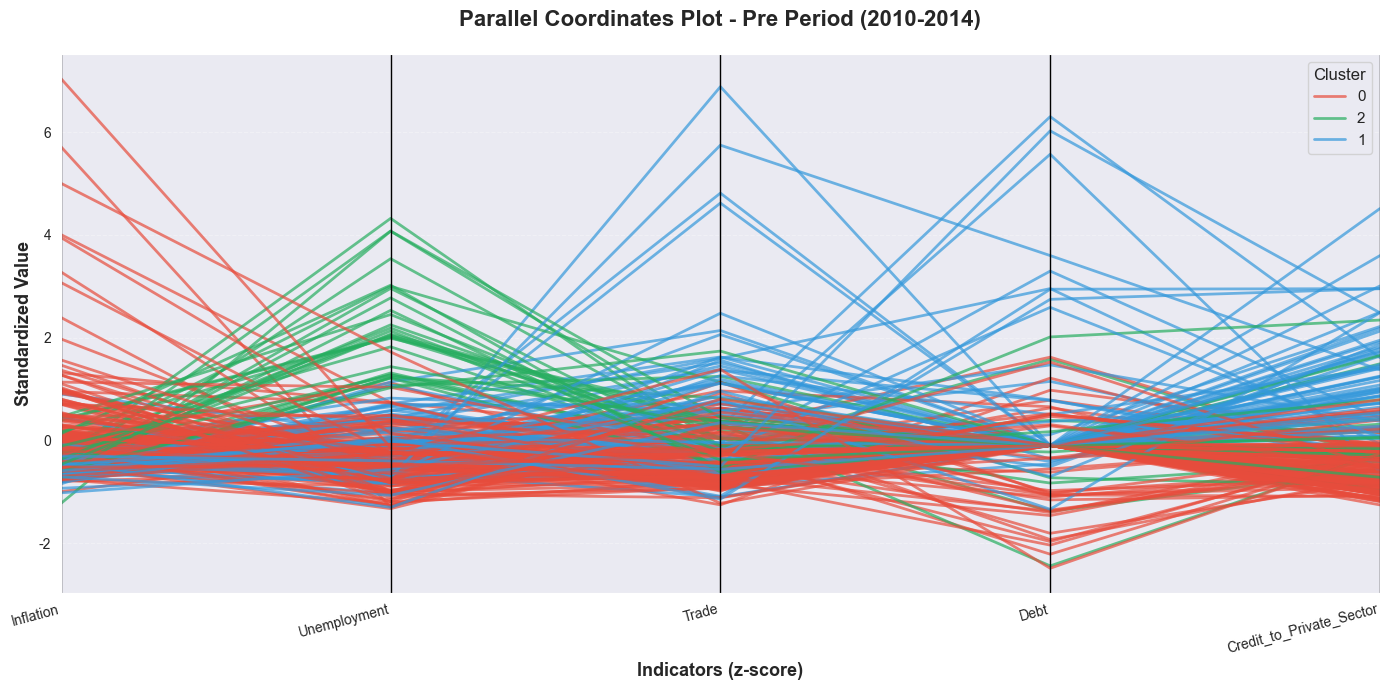

In [26]:
from pandas.plotting import parallel_coordinates

def plot_parallel_coordinates(df_std, labels, period_name, filename):
    """
    Plot parallel coordinates
    """
    # Prepare data
    plot_data = df_std[core_indicators].copy()
    plot_data['Cluster'] = labels
    plot_data['Cluster'] = plot_data['Cluster'].astype(str)
    
    # Create figure
    plt.figure(figsize=(14, 7))
    
    # Plot parallel coordinates - use higher contrast colors
    colors = ['#E74C3C', '#27AE60', '#3498DB']  # Red, Green, Blue - more obvious contrast
    parallel_coordinates(plot_data, 'Cluster', color=colors, alpha=0.7, linewidth=2.0)
    
    plt.title(f'Parallel Coordinates Plot - {period_name} Period ({PRE_YEARS[0] if period_name == "Pre" else POST_YEARS[0]}-{PRE_YEARS[1] if period_name == "Pre" else POST_YEARS[1]})', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Indicators (z-score)', fontsize=13, fontweight='bold')
    plt.ylabel('Standardized Value', fontsize=13, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.legend(title='Cluster', title_fontsize=12, fontsize=11, loc='best')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Parallel coordinates plot saved: {filename}")
    plt.show()

# Plot Pre period parallel coordinates
plot_parallel_coordinates(df_pre_std, labels_pre, 'Pre', 'fig/pcp_pre.png')


Parallel coordinates plot saved: fig/pcp_post.png


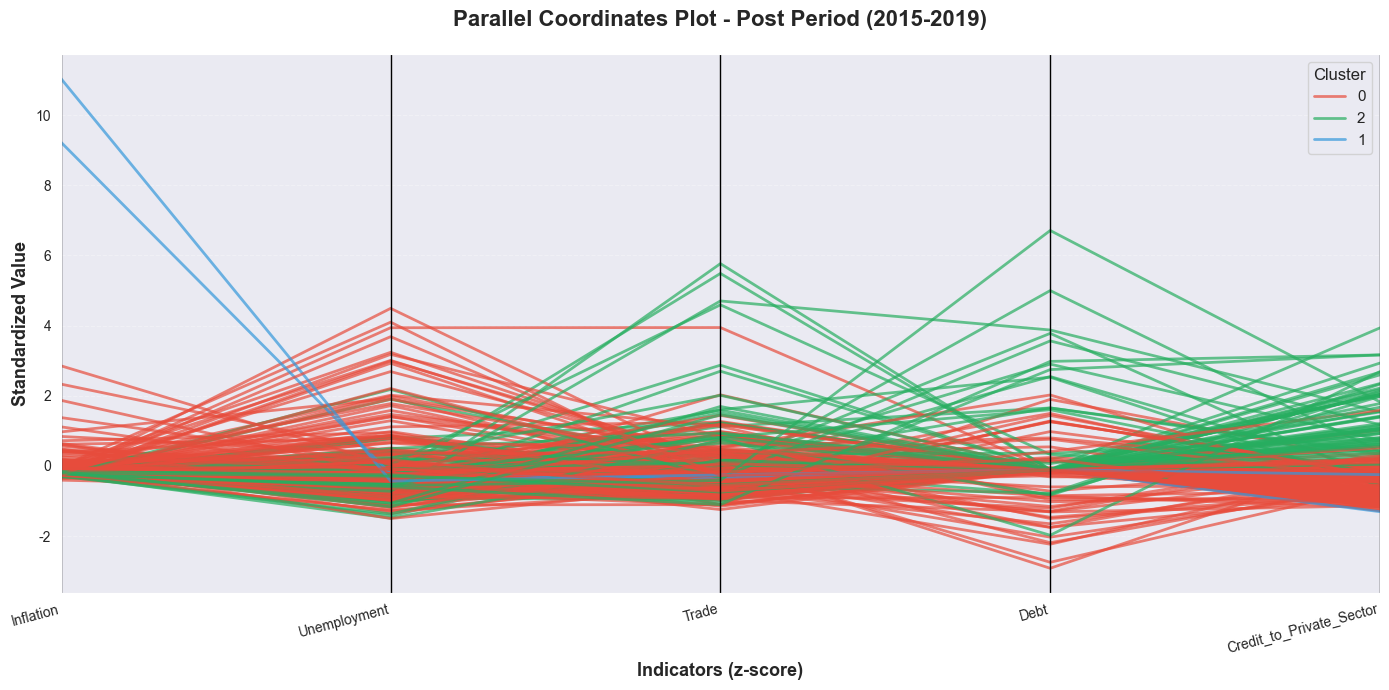

In [27]:
# Plot Post period parallel coordinates
plot_parallel_coordinates(df_post_std, labels_post, 'Post', 'fig/pcp_post.png')


### 9.2 Heatmap - Cluster Characteristics


Heatmap saved: fig/heat_pre.png


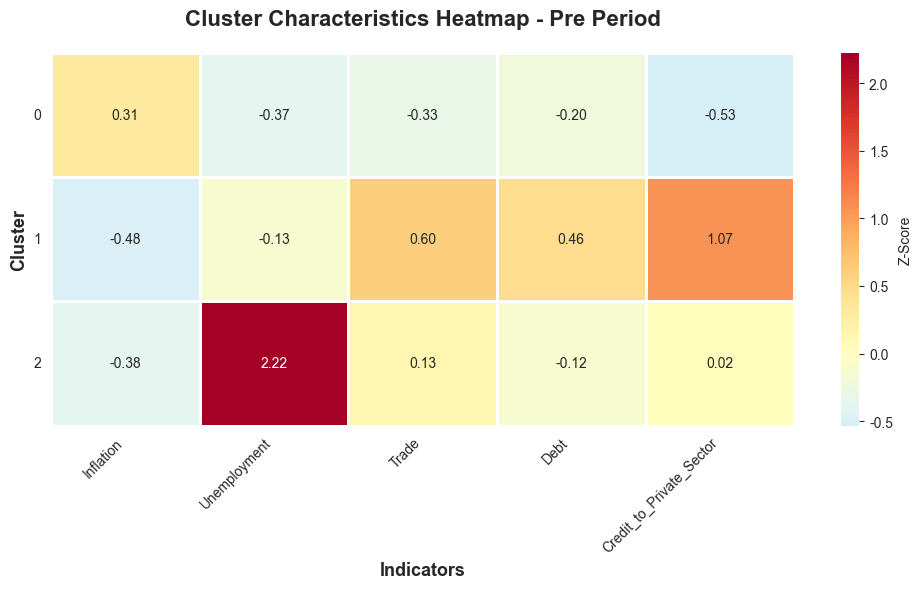

In [28]:
def plot_heatmap(group_means, period_name, filename):
    """
    Plot cluster × indicator heatmap
    """
    plt.figure(figsize=(10, 6))
    
    # Plot heatmap
    sns.heatmap(group_means, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                center=0, linewidths=1, linecolor='white',
                cbar_kws={'label': 'Z-Score'})
    
    plt.title(f'Cluster Characteristics Heatmap - {period_name} Period', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Indicators', fontsize=13, fontweight='bold')
    plt.ylabel('Cluster', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved: {filename}")
    plt.show()

# Plot Pre period heatmap
plot_heatmap(group_means_pre_std, 'Pre', 'fig/heat_pre.png')


Heatmap saved: fig/heat_post.png


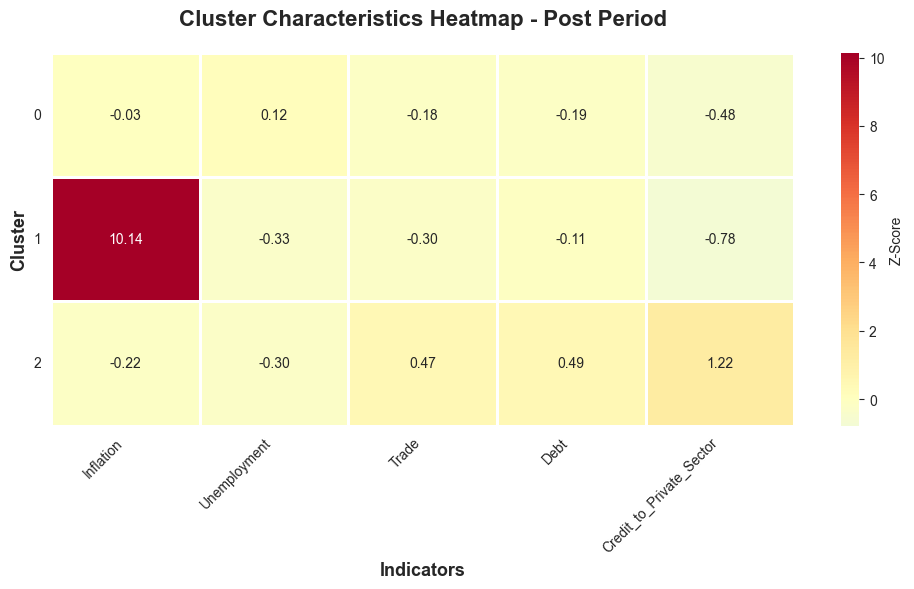

In [29]:
# Plot Post period heatmap
plot_heatmap(group_means_post_std, 'Post', 'fig/heat_post.png')


### 9.3 Sankey Diagram - Cluster Migration


In [30]:
# Use plotly to plot Sankey diagram
def plot_sankey(migration_edges, filename):
    """
    Plot Sankey diagram showing cluster migration
    """
    # Prepare node labels
    node_labels = [f'Pre-Group {i}' for i in range(3)] + [f'Post-Group {i}' for i in range(3)]
    
    # Prepare sources, targets and values
    sources = []
    targets = []
    values = []
    
    for _, row in migration_edges.iterrows():
        sources.append(int(row['pre_group']))  # Pre cluster index
        targets.append(int(row['post_group']) + 3)  # Post cluster index (offset by 3)
        values.append(int(row['count']))
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=node_labels,
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FF6B6B', '#4ECDC4', '#45B7D1']
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color='rgba(0,0,0,0.2)'
        )
    )])
    
    fig.update_layout(
        title=dict(
            text='Cluster Migration Flow (Pre → Post Period)',
            font=dict(size=20, family='Arial Black', color='black')
        ),
        font=dict(size=12, color='black'),
        plot_bgcolor='white',  # Set plot area background to white
        paper_bgcolor='white',  # Set overall background to white
        height=600,
        width=1000
    )
    
    # Save as static image
    try:
        fig.write_image(filename, width=1000, height=600)
        print(f"Sankey diagram saved: {filename}")
    except Exception as e:
        print(f"Cannot save as PNG (may need to install kaleido): {e}")
        print("Trying to save as HTML file...")
        fig.write_html(filename.replace('.png', '.html'))
        print(f"Sankey diagram saved as HTML: {filename.replace('.png', '.html')}")
    
    # Display interactive figure
    fig.show()

# Plot Sankey diagram
plot_sankey(migration_counts, 'fig/sankey_migration.png')


Cannot save as PNG (may need to install kaleido): 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Trying to save as HTML file...
Sankey diagram saved as HTML: fig/sankey_migration.html


### 9.4 Line Chart + Changepoint Annotation


Changepoint line chart saved: fig/changepoint_lines.png


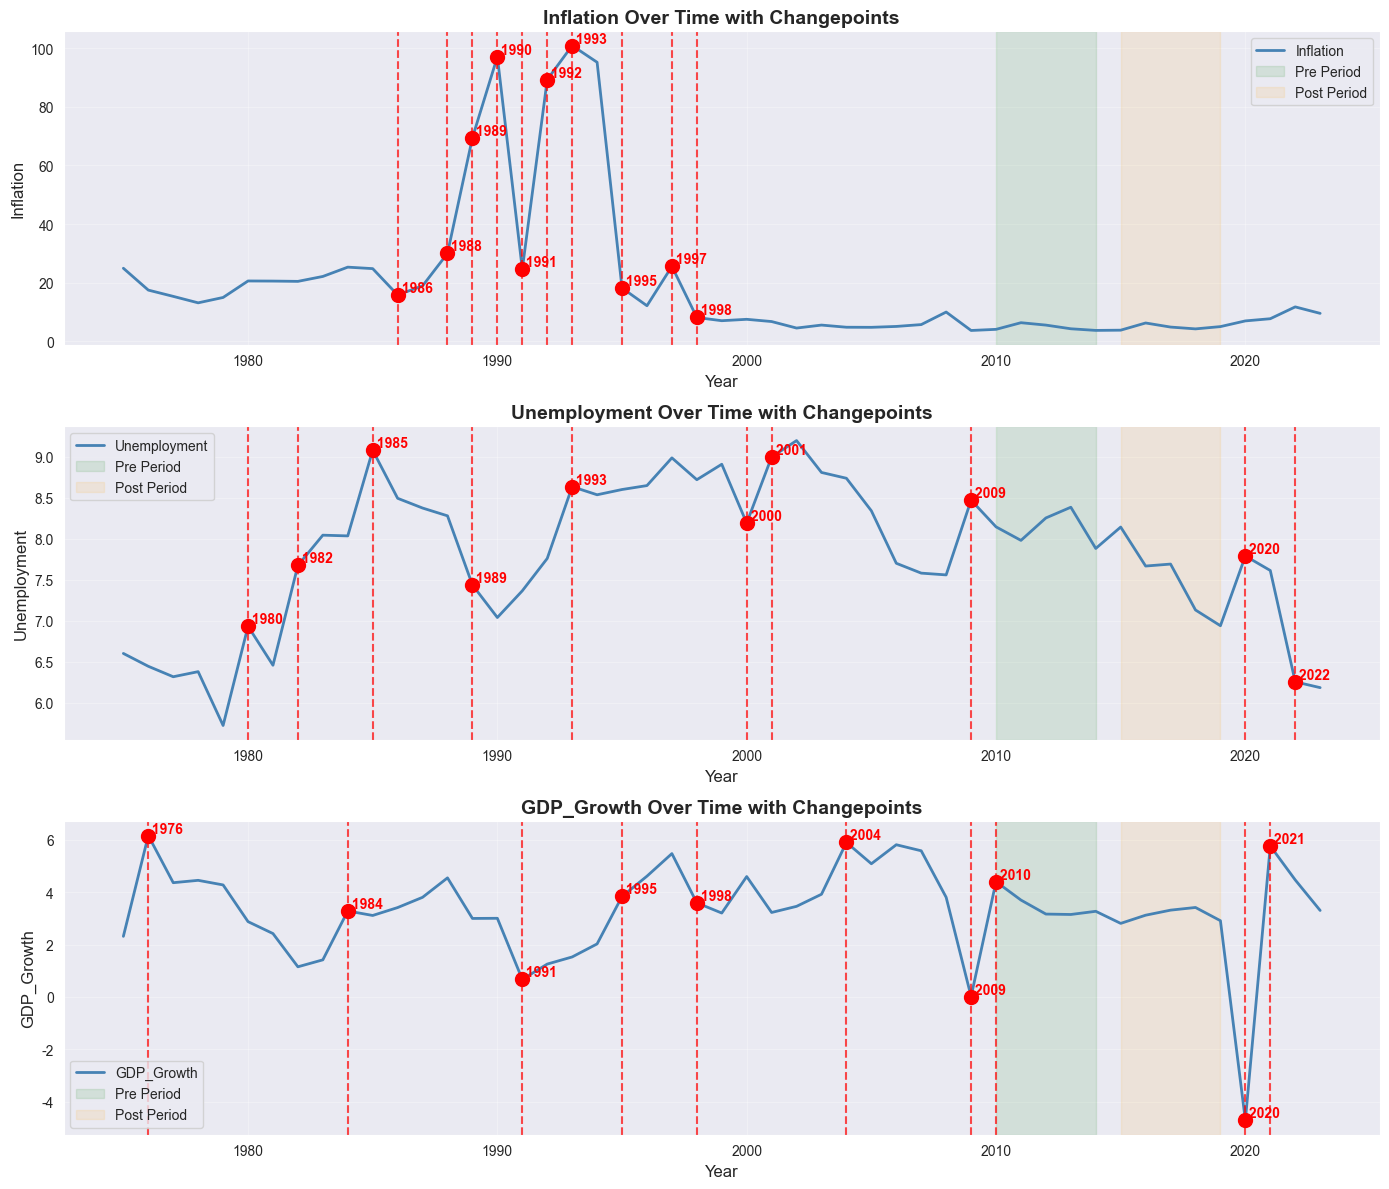

In [31]:
def plot_changepoint_lines(df_yearly, changepoints_dict, filename):
    """
    Plot key indicator line charts and annotate changepoints
    """
    fig, axes = plt.subplots(len(changepoint_indicators), 1, figsize=(14, 4 * len(changepoint_indicators)))
    
    if len(changepoint_indicators) == 1:
        axes = [axes]
    
    for idx, indicator in enumerate(changepoint_indicators):
        ax = axes[idx]
        
        # Plot line
        data = df_yearly[['Year', indicator]].dropna()
        ax.plot(data['Year'], data[indicator], linewidth=2, color='steelblue', label=indicator)
        
        # Annotate changepoints
        if indicator in changepoints_dict and len(changepoints_dict[indicator]) > 0:
            for cp_year in changepoints_dict[indicator]:
                if cp_year in data['Year'].values:
                    cp_value = data[data['Year'] == cp_year][indicator].values[0]
                    ax.axvline(x=cp_year, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
                    ax.scatter([cp_year], [cp_value], color='red', s=100, zorder=5)
                    ax.text(cp_year, cp_value, f' {int(cp_year)}', fontsize=10, 
                           verticalalignment='bottom', color='red', fontweight='bold')
        
        # Annotate Pre and Post periods
        ax.axvspan(PRE_YEARS[0], PRE_YEARS[1], alpha=0.1, color='green', label='Pre Period')
        ax.axvspan(POST_YEARS[0], POST_YEARS[1], alpha=0.1, color='orange', label='Post Period')
        
        ax.set_title(f'{indicator} Over Time with Changepoints', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel(indicator, fontsize=12)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Changepoint line chart saved: {filename}")
    plt.show()

# Plot changepoint line chart
plot_changepoint_lines(df_yearly, changepoints_dict, 'fig/changepoint_lines.png')


In [32]:
# Prepare box plot data: select 1-3 core indicators
box_indicators = ['Inflation', 'Unemployment', 'Trade']  # Can be adjusted as needed

# Merge Pre and Post data
df_pre_box = df_pre_imputed[['Country Name'] + box_indicators].copy()
df_pre_box['Period'] = 'Pre'

df_post_box = df_post_imputed[['Country Name'] + box_indicators].copy()
df_post_box['Period'] = 'Post'

df_box = pd.concat([df_pre_box, df_post_box], ignore_index=True)

print("Box plot data preview:")
print(df_box.head())


Box plot data preview:
                  Country Name  Inflation  Unemployment      Trade Period
0                  Afghanistan   6.496741       4.80350  75.735336    Pre
1  Africa Eastern and Southern   6.605575       6.44960  62.832956    Pre
2   Africa Western and Central   3.002509       4.42405  75.735336    Pre
3                      Albania   2.530050      14.97280  76.794342    Pre
4                      Algeria   4.699578      10.18340  60.508699    Pre


Box plot saved: fig/box_sig.png


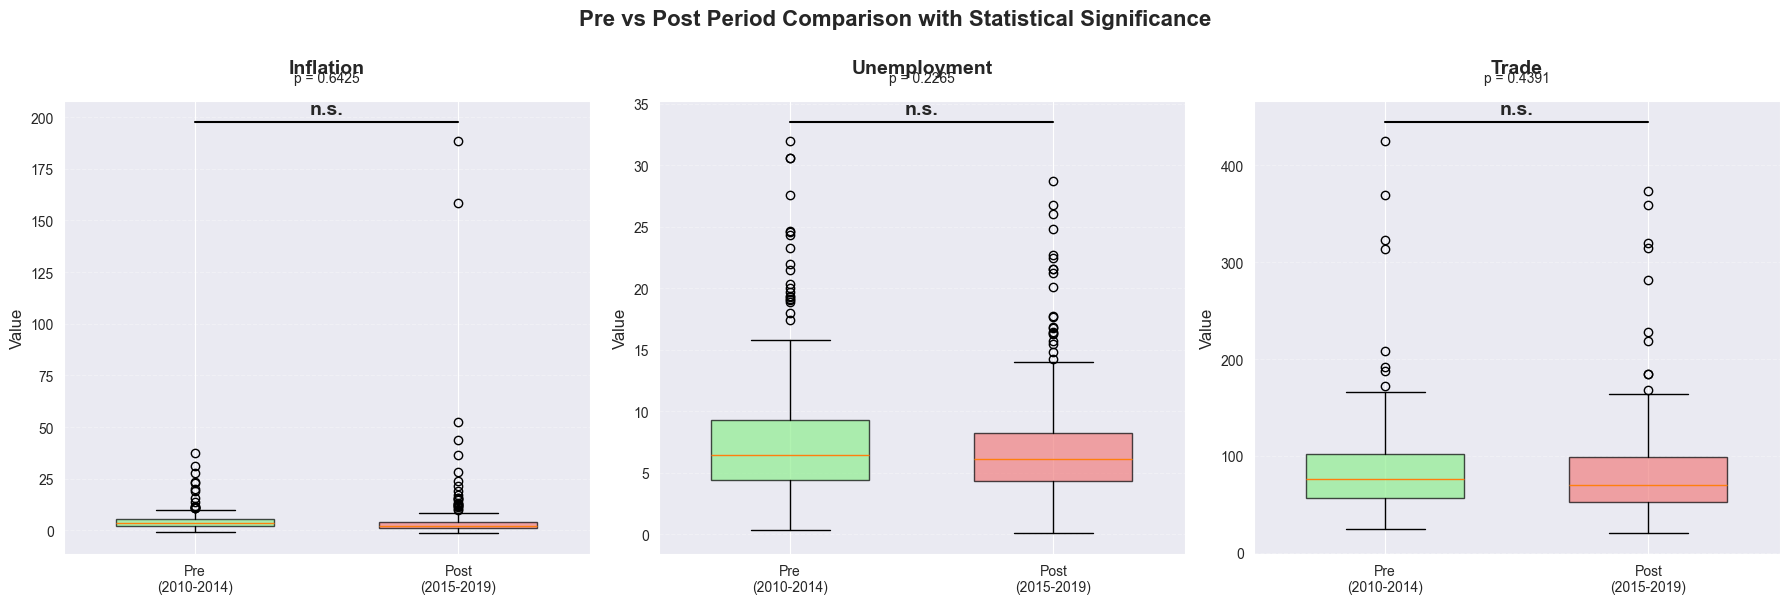

In [33]:
def plot_boxplot_with_significance(df_box, indicators, stats_summary, filename):
    """
    Plot box plot and annotate significance
    """
    fig, axes = plt.subplots(1, len(indicators), figsize=(6 * len(indicators), 6))
    
    if len(indicators) == 1:
        axes = [axes]
    
    for idx, indicator in enumerate(indicators):
        ax = axes[idx]
        
        # Plot box plot
        box_data = [df_box[df_box['Period'] == 'Pre'][indicator].dropna(),
                    df_box[df_box['Period'] == 'Post'][indicator].dropna()]
        
        bp = ax.boxplot(box_data, labels=['Pre\n(2010-2014)', 'Post\n(2015-2019)'],
                        patch_artist=True, widths=0.6)
        
        # Set colors
        colors = ['lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Add significance annotation
        stat_row = stats_summary[stats_summary['Indicator'] == indicator]
        if len(stat_row) > 0:
            p_value = stat_row['T_PValue'].values[0]
            if p_value < 0.001:
                sig_text = '***'
            elif p_value < 0.01:
                sig_text = '**'
            elif p_value < 0.05:
                sig_text = '*'
            else:
                sig_text = 'n.s.'
            
            # Add significance mark on plot
            y_max = max([d.max() for d in box_data if len(d) > 0])
            y_min = min([d.min() for d in box_data if len(d) > 0])
            y_range = y_max - y_min
            
            # Draw significance line
            y_sig = y_max + y_range * 0.05
            ax.plot([1, 2], [y_sig, y_sig], 'k-', linewidth=1.5)
            ax.text(1.5, y_sig + y_range * 0.02, sig_text, ha='center', fontsize=14, fontweight='bold')
            
            # Add p-value
            ax.text(1.5, y_max + y_range * 0.15, f'p = {p_value:.4f}', ha='center', fontsize=10)
        
        ax.set_title(f'{indicator}', fontsize=14, fontweight='bold', pad=20)
        ax.set_ylabel('Value', fontsize=12)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add overall title
    fig.suptitle('Pre vs Post Period Comparison with Statistical Significance', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Box plot saved: {filename}")
    plt.show()

# Plot box plot
plot_boxplot_with_significance(df_box, box_indicators, stats_summary, 'fig/box_sig.png')
